In [1]:
import os
import torch
import yaml
import glob
import torchvision.transforms as transforms
import torchvision.utils as vutils
from PIL import Image
import numpy as np

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    # for cuda
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
set_seed(0)

In [4]:
def extract_files():
    import google.colab
    import zipfile

    google.colab.drive.mount('/content/drive')
    PROJECT_DIR = "/content/drive/MyDrive/thesis/data/"

    zip_ref = zipfile.ZipFile(PROJECT_DIR + "fiveK.zip", 'r')
    zip_ref.extractall(".")
    zip_ref.close()

In [5]:
if 'google.colab' in str(get_ipython()):
  extract_files()
  config_path = "/content/drive/MyDrive/thesis/config.yaml"
else:
  config_path = "../../config.yaml"

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [7]:
try:
    # Load configuration
    with open(config_path, 'r') as config_file:
        config = yaml.safe_load(config_file)
except:
    raise FileNotFoundError(f"Config file not found at path: {config_path}")

In [8]:
loss_type = config['unetmodel']['loss']
depth = config['unetmodel']['depth']
lambda_ = config['unetmodel']['contrastive_lambda']
base_checkpoint_path = f"{config['paths']['unetcheckpoints']}_five_classes_contrastive_{loss_type}_{depth}_{lambda_}"

In [9]:
def load_best_checkpoint(checkpoint_dir):
    # Check if the directory exists
    if not os.path.exists(base_checkpoint_path):
        print(f"No directory found: {checkpoint_dir}")
        return None
      # Get a list of all checkpoint files in the directory
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, f'unet_*.pth'))

    # sort the checkpoint files according to the epoch number
    checkpoint_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

    # Check if any checkpoint files are present
    if not checkpoint_files:
        print(f"No checkpoints found in the directory: {checkpoint_dir}")
        return None

    best_val_loss = float('inf')
    epochs = []
    train_losses = []
    val_losses = []
    for checkpoint_file in checkpoint_files:
        checkpoint = torch.load(checkpoint_file, map_location=torch.device(device))
        epochs.append(checkpoint['epoch'])
        train_losses.append(checkpoint['train_loss'])
        val_losses.append(checkpoint['val_loss'])
        if checkpoint['val_loss'] < best_val_loss:
            best_val_loss = checkpoint['val_loss']
            best_checkpoint = checkpoint

    return best_checkpoint, epochs, train_losses, val_losses

In [10]:
checkpoint, epochs, train_losses, val_losses = load_best_checkpoint(base_checkpoint_path)

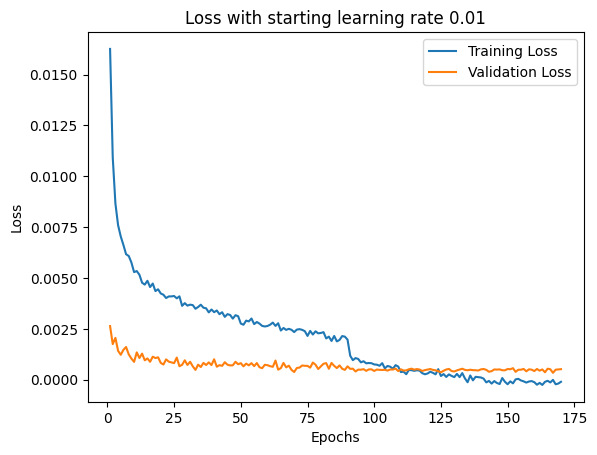

In [11]:
# Draw the plot between epochs and accuracies
import matplotlib.pyplot as plt
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss with starting learning rate 0.01')
plt.show()

In [12]:
class ConvBlock(torch.nn.Module):
    def __init__(self, inchannels, outchannels, downscale=False, upscale=False):
        super(ConvBlock, self).__init__()
        self.down = torch.nn.MaxPool2d(2) if downscale else torch.nn.Identity()
        self.conv1 = torch.nn.Conv2d(inchannels, outchannels, 3, padding=1)
        self.bnorm1 = torch.nn.InstanceNorm2d(outchannels)
        self.conv2 = torch.nn.Conv2d(outchannels, outchannels, 3, padding=1)
        self.bnorm2 = torch.nn.InstanceNorm2d(outchannels)
        self.up = torch.nn.Upsample(scale_factor=2) if upscale else torch.nn.Identity()

    def forward(self, x):
        x = self.down(x)
        x = torch.nn.functional.relu(self.bnorm1(self.conv1(x)))
        x = torch.nn.functional.relu(self.bnorm2(self.conv2(x)))
        x = self.up(x)
        return x

In [13]:
class UNet(torch.nn.Module):
    def __init__(self, classes, depth):
        super(UNet, self).__init__()
        self.encoder = torch.nn.ModuleList()
        channels = [3] + [64 * (2 ** i) for i in range(depth)]
        for i in range(depth):
            self.encoder.append(ConvBlock(channels[i], channels[i + 1], downscale=(i > 0)))
        
        self.embedding = torch.nn.Embedding(classes, channels[-1])
        self.bottleneck = ConvBlock(channels[-1], channels[-1], downscale=True, upscale=True)
        
        self.decoder = torch.nn.ModuleList()
        self.linear = torch.nn.ModuleList()
        channels[0] = 64
        for i in range(depth - 1, -1, -1):
            self.decoder.append(ConvBlock(2 * channels[i + 1], channels[i], upscale=(i > 0)))
            self.linear.append(torch.nn.Linear(channels[-1], 2 * channels[i] if i > 0 else channels[i], bias=False))

        self.output = torch.nn.Sequential(
            torch.nn.Conv2d(channels[0], 3, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x, label_first, label_second, alpha):
        skip = []
        for mod in self.encoder:
            x = mod(x)
            skip.append(x)
        emb_a = self.embedding(label_first)
        emb_b = self.embedding(label_second)
        # Expand alpha to match the batch size
        alpha = alpha.view(-1, 1) 
        emb = alpha * emb_a + (1 - alpha) * emb_b
        x = x + emb.unsqueeze(-1).unsqueeze(-1)
        x = self.bottleneck(x)
        for mod, linear in zip(self.decoder, self.linear):
            y = skip.pop()
            # add embedding with the decoder input
            x = x + linear(emb).unsqueeze(-1).unsqueeze(-1)
            x = torch.cat([x, y], 1)
            x = mod(x)
        x = self.output(x)
        return x

In [14]:
depth = config['unetmodel']['depth']
net = UNet(classes=5, depth=3)
net = net.to(device)

In [15]:
net.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [16]:
print(checkpoint['epoch'])

167


In [17]:
print(checkpoint['val_loss'])

0.0003368294155225158


In [54]:
alphas = [-0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]

In [67]:
MEAN = [0.2279, 0.2017, 0.1825]
STD = [0.1191, 0.1092, 0.1088]
raw_img_path = os.path.join(config['paths']['data'], 'raw', '0612.png')
labels_a =  torch.Tensor().type(torch.int).to(device)
labels_b =  torch.Tensor().type(torch.int).to(device)

raw = torch.Tensor().to(device)
for alpha in alphas:
    test_tr = transforms.Compose([
          transforms.ToTensor(),
          transforms.CenterCrop(224),
          transforms.Normalize(mean=MEAN, std=STD)
    ])
    raw = torch.cat((raw, test_tr(Image.open(raw_img_path)).unsqueeze(0)))
    # first label is expA and second label is expB     
    labels_a = torch.cat((labels_a, torch.Tensor([0]).type(torch.int).to(device)))
    labels_b = torch.cat((labels_b, torch.Tensor([1]).type(torch.int).to(device)))

with torch.no_grad():
    outputs = net(raw.to(device), labels_a, labels_b, torch.Tensor(alphas).to(device))

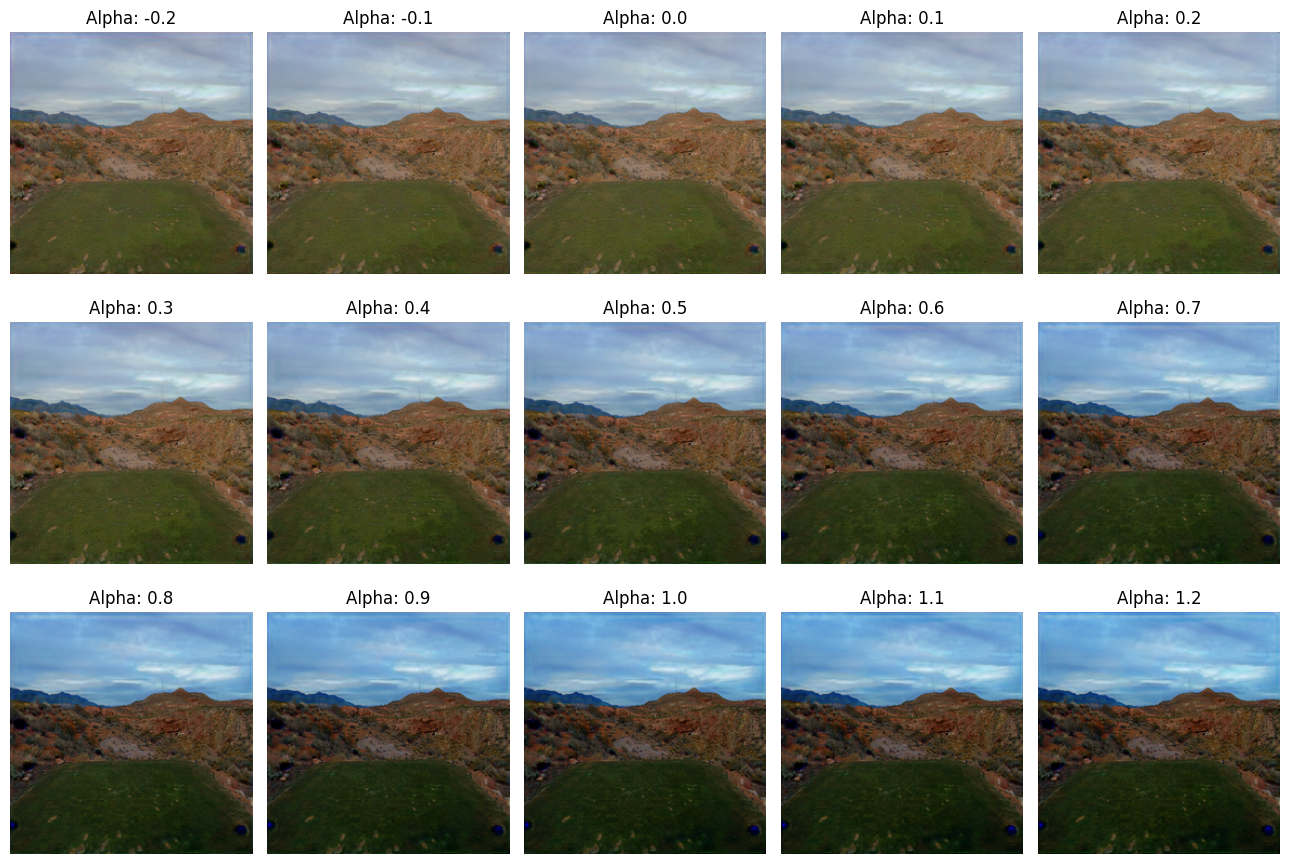

In [68]:
num_images = len(outputs)

cols = 5
rows = 3

fig, axs = plt.subplots(rows, cols, figsize=(13,9))

axs = axs.flatten()

for i in range(num_images):
    axs[i].set_title(f'Alpha: {alphas[i]}')
    axs[i].imshow(outputs[i].cpu().permute(1, 2, 0).numpy())
    axs[i].axis('off')

# Hide any remaining empty subplots
for j in range(num_images, len(axs)):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

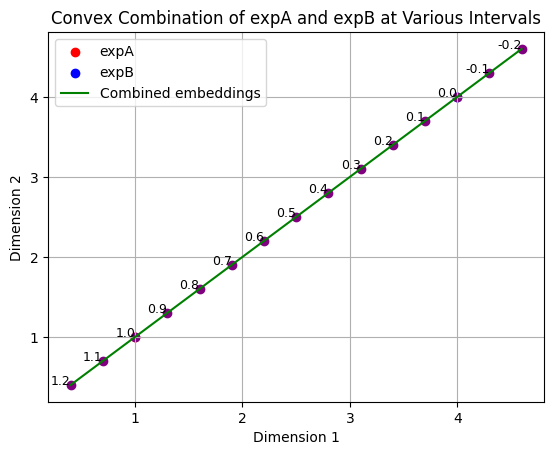

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Example 2D embeddings
expA = np.array([1, 1])
expB = np.array([4, 4])

# Alphas to demonstrate the combination at intervals of 0.1, including values outside [0, 1]
alphas = np.concatenate((np.array([-0.2, -0.1]), np.linspace(0, 1, 11), np.array([1.1, 1.2])))

# Calculate combined embeddings for the specified alphas
embeddings = np.array([alpha * expA + (1 - alpha) * expB for alpha in alphas])

# Plot expA and expB
plt.scatter(*expA, color='red', label='expA')
plt.scatter(*expB, color='blue', label='expB')

# Plot the combined embeddings
plt.plot(embeddings[:, 0], embeddings[:, 1], color='green', label='Combined embeddings')

# Mark the specific alpha points
for i, alpha in enumerate(alphas):
    plt.scatter(embeddings[i, 0], embeddings[i, 1], color='purple')
    plt.text(embeddings[i, 0], embeddings[i, 1], f'{alpha:.1f}', fontsize=9, ha='right')

# Add labels and legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Convex Combination of expA and expB at Various Intervals')
plt.legend()
plt.grid(True)
plt.show()